In [1]:
# Install necessary packages
# !pip install ydata-profiling
# !pip install sweetviz
# !pip install japanize-matplotlib
# !pip install pmdarima

# !pip install optuna

In [2]:

# Import libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import ydata_profiling as pdp  # Use ydata_profiling instead of pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import pmdarima as pm
import datetime
import math
import os
import sweetviz as sv

import japanize_matplotlib
japanize_matplotlib.japanize()

from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import optuna
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb

!pip install jpholiday
import jpholiday

In [3]:
df = pd.read_csv('/Users/kubotariku/Desktop/datamix/03_Advance step/ICAreport/cinemaTicket_Ref.csv')

# EDA

In [5]:
df.dtypes

film_code         int64
cinema_code       int64
total_sales       int64
tickets_sold      int64
tickets_out       int64
show_time         int64
occu_perc       float64
ticket_price    float64
ticket_use        int64
capacity        float64
date             object
month             int64
quarter           int64
day               int64
dtype: object

In [6]:
df['date'] = pd.to_datetime(df['date'])

In [7]:
# #sweetvizを使用
# report = sv.analyze(df)
# report.show_html("eda.html")

In [8]:
# pdp.ProfileReport(df)

In [9]:
#欠損値の確認

# df.isnull().sum()

# # null値を含む行を抽出
# null_rows = df[df['occu_perc'].isnull() | df['capacity'].isnull()]

# # 抽出した行のデータを表示
# print(null_rows)

# df[df['tickets_out']>0]['tickets_out'].sum()

df[df['tickets_out']==311].head(23)

#これだけじゃこの欠損データが何かわからないので、各特徴量ごとにEDA

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
109657,1482,518,64560000,883,311,11,64.26,73114.382786,572,1374.105198,2018-04-25,4,2,25


In [10]:
# subset_df = df.drop(df.columns[10:14], axis=1)

# # 散布図行列の作成
# sns.pairplot(subset_df, diag_kind='kde')
# plt.figure(figsize=(1, 1))

# plt.show()

In [11]:
# df.info()
# len(df['film_code'].unique())

# sns.histplot(df['film_code'], bins=30, kde=True)  # ヒストグラムを描画
# plt.title('Histogram of film_code')  # タイトルを設定
# plt.xlabel('Film Code')  # x軸のラベルを設定
# plt.ylabel('Frequency')  # y軸のラベルを設定
# plt.show()


grouped_data = df.groupby(['film_code', 'show_time'], as_index=False).size()
print(grouped_data)

#show_timeは上映回数

     film_code  show_time  size
0         1471          1   146
1         1471          2    72
2         1471          3   165
3         1471          4    38
4         1471          5    25
..         ...        ...   ...
733       1589          2    20
734       1589          3    15
735       1589          4     1
736       1589          5     1
737       1589          6     4

[738 rows x 3 columns]


In [12]:
# 映画ごとに売り上げを集計
film_df = df.groupby('film_code')['total_sales'].sum()

# 売り上げが最も高い映画を取得
top_selling_movie = film_df.idxmax()
top_df_amount = film_df.max()

print("売り上げが最も高い映画:", top_selling_movie)
print("売り上げ額:", top_df_amount)

# 映画館ごとに上映されている映画の数を集計
cinema_movie_counts = df.groupby('cinema_code')['film_code'].nunique()

# 映画館ごとに上映されている映画の数の統計情報を表示
print("映画館の上映filmの構成:")
print(cinema_movie_counts.describe())


売り上げが最も高い映画: 1554
売り上げ額: 372740376637
映画館の上映filmの構成:
count    246.000000
mean      19.882114
std       10.911066
min        1.000000
25%       13.000000
50%       18.000000
75%       25.750000
max       48.000000
Name: film_code, dtype: float64


# クラスタリング
### 数多ある映画館をグループ分け

In [14]:
df[df['cinema_code']==32].head(100)

,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
24160,1563,32,8700000,145,0,16,1.93,60000.0,145,7512.953368,2018-09-25,9,3,25
24233,1563,32,7800000,78,0,14,1.19,100000.0,78,6554.621849,2018-09-24,9,3,24
24292,1563,32,6800000,68,0,14,1.03,100000.0,68,6601.941748,2018-09-23,9,3,23
24348,1563,32,7260000,121,0,10,2.57,60000.0,121,4708.171206,2018-09-18,9,3,18
24379,1563,32,11000000,110,0,14,1.67,100000.0,110,6586.826347,2018-09-17,9,3,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68337,1483,32,81100000,811,0,16,10.78,100000.0,811,7523.191095,2018-04-20,4,2,20
68444,1483,32,63700000,637,0,16,8.47,100000.0,637,7520.661157,2018-04-19,4,2,19
68577,1483,32,17200000,172,0,16,2.29,100000.0,172,7510.917031,2018-04-18,4,2,18
68660,1483,32,98400000,1640,0,16,21.81,60000.0,1640,7519.486474,2018-04-17,4,2,17


In [15]:
#欠損値の処理
df_cluster = df.dropna()
df_cluster = df_cluster.drop(columns=['ticket_price','film_code', 'date', 'month', 'quarter', 'day'])

# 'cinema_code'でグループ化し、その他の列を合計
grouped_df = df_cluster.groupby('cinema_code').sum().reset_index()
grouped_df.info()
grouped_df['capacity_per_showtime'] = grouped_df['capacity'] / grouped_df['show_time']

grouped_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cinema_code   244 non-null    int64  
 1   total_sales   244 non-null    int64  
 2   tickets_sold  244 non-null    int64  
 3   tickets_out   244 non-null    int64  
 4   show_time     244 non-null    int64  
 5   occu_perc     244 non-null    float64
 6   ticket_use    244 non-null    int64  
 7   capacity      244 non-null    float64
dtypes: float64(2), int64(6)
memory usage: 15.4 KB


,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_use,capacity,capacity_per_showtime
0,32,9273549998,110016,2,3200,1603.64,110014,1.503791e+06,469.934708
1,33,3947850000,45647,22,2771,2399.17,45625,9.832937e+05,354.851572
2,34,26891660000,282318,182,4473,29581.23,282136,1.180830e+06,263.990561
3,35,12952150000,167578,96,2336,32337.62,167482,3.875870e+05,165.919090
4,39,13126359999,162328,18,3939,16114.95,162310,1.158496e+06,294.109279


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

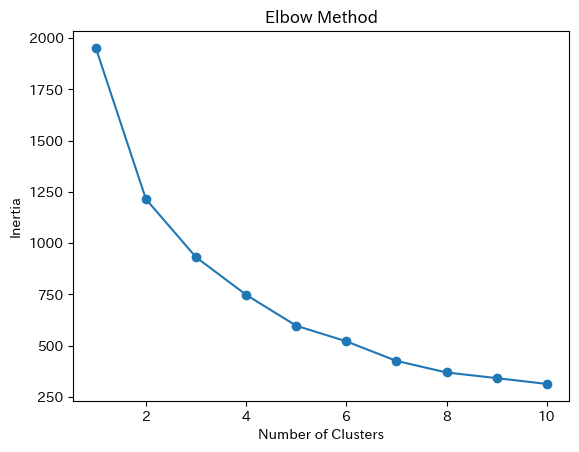

In [16]:
# 標準化ありエルボー法を実施
features = grouped_df[['total_sales', 'tickets_sold', 'tickets_out', 'show_time', 'occu_perc', 'ticket_use', 'capacity', 'capacity_per_showtime']]

# 特徴量の標準化
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# エルボー法によるクラスタ数の決定
inertia = []
for n_clusters in range(1, 11):  # クラスタ数を1から10まで試す
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# エルボー法の結果を可視化
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

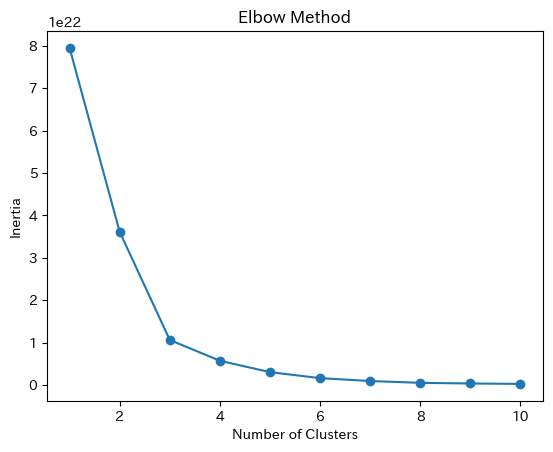

In [17]:
# エルボー法を実施
features = grouped_df[['total_sales', 'tickets_sold', 'tickets_out', 'show_time', 'occu_perc', 'ticket_use', 'capacity', 'capacity_per_showtime']]

# エルボー法によるクラスタ数の決定
inertia = []
for n_clusters in range(1, 11):  # クラスタ数を1から10まで試す
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

# エルボー法の結果を可視化
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [18]:
# KMeansクラスタリングの実行
kmeans = KMeans(n_clusters=3, random_state=0)  # クラスタの数は適宜調整
kmeans.fit(scaled_features)

# クラスタリング結果の追加
grouped_df['cluster'] = kmeans.labels_

grouped_df.head(100)

# # Excelファイルに書き出し
# output_excel_path = '/Users/kubotariku/Desktop/datamix/03_Advance step/ICAreport/cinema_cluster.xlsx'  # 書き出すExcelファイルのパスを指定してください
# grouped_df.to_excel(output_excel_path, index=False)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_use,capacity,capacity_per_showtime,cluster
0,32,9273549998,110016,2,3200,1603.64,110014,1.503791e+06,469.934708,0
1,33,3947850000,45647,22,2771,2399.17,45625,9.832937e+05,354.851572,1
2,34,26891660000,282318,182,4473,29581.23,282136,1.180830e+06,263.990561,0
3,35,12952150000,167578,96,2336,32337.62,167482,3.875870e+05,165.919090,0
4,39,13126359999,162328,18,3939,16114.95,162310,1.158496e+06,294.109279,0
...,...,...,...,...,...,...,...,...,...,...
95,285,1517260000,23607,3,2171,6353.54,23604,2.435773e+05,112.195907,1
96,286,968620000,18488,64,573,3720.35,18424,1.432498e+05,249.999687,1
97,291,7016410000,136388,28,4444,13455.65,136360,8.063297e+05,181.442325,0
98,292,1062020000,24234,0,1250,4647.58,24234,2.274975e+05,181.998006,1


In [19]:
#クラスターを追加したdf作成

grouped_df_cluster = grouped_df[["cinema_code","cluster"]]

df = pd.merge(df,grouped_df_cluster,on='cinema_code',how='left')

In [20]:
# # # Excelファイルに書き出し
# output_excel_path = '/Users/kubotariku/Desktop/datamix/03_Advance step/ICAreport/cinema_cluster_all.xlsx'  # 書き出すExcelファイルのパスを指定してください
# df.to_excel(output_excel_path, index=False)

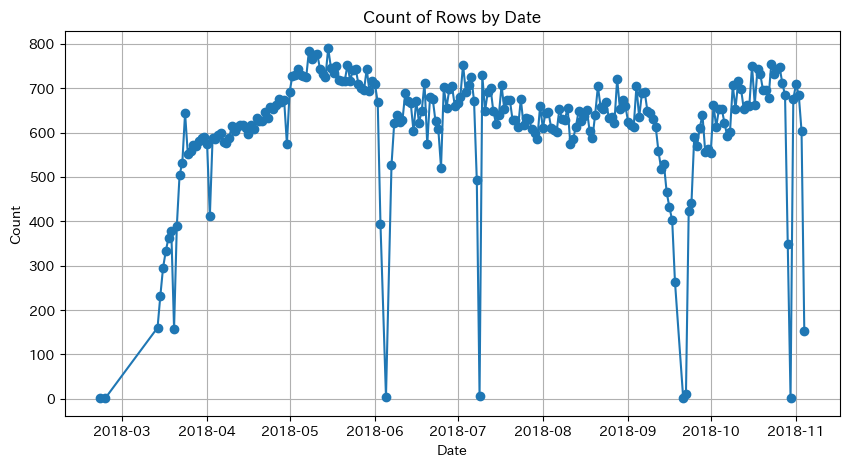

In [21]:
# 日付ごとに行数をカウント
#定休日らしき日を特定

count_by_date = df.groupby('date').size().reset_index(name='count')

# プロット
plt.figure(figsize=(10, 5))
plt.plot(count_by_date['date'], count_by_date['count'], marker='o')
plt.title('Count of Rows by Date')
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid(True)
plt.show()

countdate_verysmall = count_by_date[(count_by_date["count"] < 100)]

In [22]:
#欠損値らしき値を保存する
countdate_verysmall

,date,count
0,2018-02-21,1
1,2018-02-23,1
84,2018-06-05,4
117,2018-07-09,7
189,2018-09-21,1
190,2018-09-22,10
228,2018-10-30,2


# 時系列分析にて傾向を掴む　まずは売り上げから 

In [24]:
df_sales = df[["total_sales","date"]]
df_sales = df_sales.set_index("date")

# 日ごとにグループ化して合計を計算
df_sales_daily = df_sales.resample('D').sum()


In [25]:
#9月までのデータを使い10月を予測する。
# 2018年9月30日までのテストデータと2018年10月1日以降のデータに分ける
train_salesdata = df_sales_daily[:'2018-09-30']
test_salesdata = df_sales_daily['2018-10-01':]

In [26]:
#trainデータに0の欠損値が含まれているため、欠損値処理。
train_salesdata[(train_salesdata["total_sales"]==0)]

# 2018-03-14までのデータを削除
train_salesdata = train_salesdata[train_salesdata.index > '2018-03-14']

# 特定の日付の値を前の週の値で置き換え
dates_to_replace = ['2018-06-04', '2018-06-06', '2018-09-19', '2018-09-20']
for date_str in dates_to_replace:
    date = pd.to_datetime(date_str)
    previous_week_date = date - pd.Timedelta(weeks=1)
    if previous_week_date in train_salesdata.index:
        train_salesdata.at[date, 'total_sales'] = train_salesdata.at[previous_week_date, 'total_sales']

In [27]:
train_salesdata[(train_salesdata["total_sales"]<10)]

,total_sales
date,


In [28]:
train_salesdata[(train_salesdata.index > '2018-03-14')]

,total_sales
date,
2018-03-15,4479008974
2018-03-16,5386645987
2018-03-17,3367302992
2018-03-18,3298541496
2018-03-19,3232929498
...,...
2018-09-26,4574450000
2018-09-27,5604900000
2018-09-28,9523550000


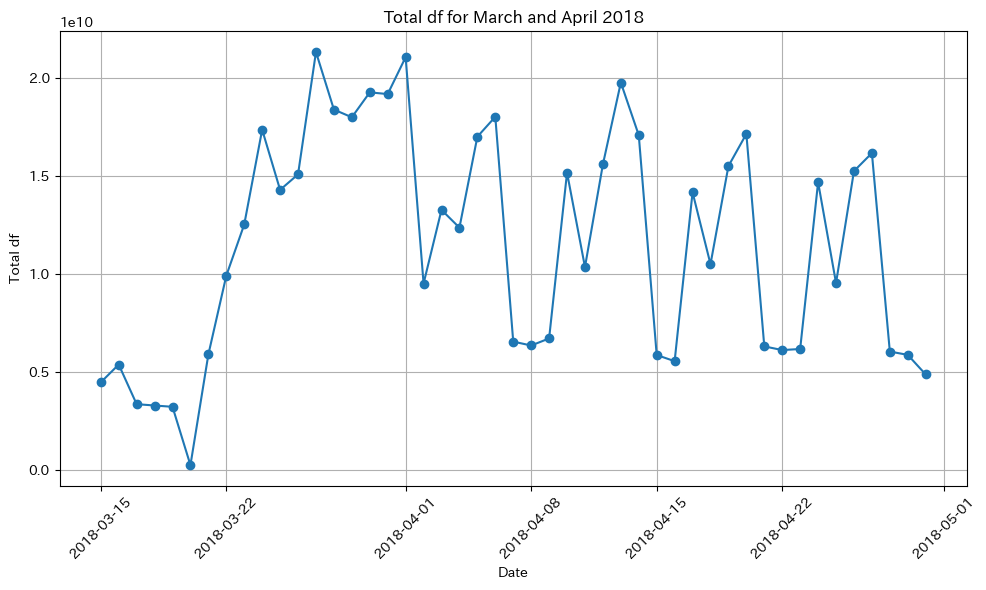

In [29]:
# 3月と4月のデータを抽出
march_april_data = train_salesdata['2018-03':'2018-04']

# データをプロット
plt.figure(figsize=(10, 6))
plt.plot(march_april_data.index, march_april_data['total_sales'], marker='o', linestyle='-')
plt.title('Total df for March and April 2018')
plt.xlabel('Date')
plt.ylabel('Total df')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# プロットを表示
plt.show()

#3月２０~の急激な上昇に違和感があるもののそのまま予測モデルを作成する

In [30]:
#日付データの粒度を確認する。
# インデックスの日付の範囲を確認
start_date = df_sales_daily.index.min()
end_date = df_sales_daily.index.max()

# 全ての日付の範囲を作成
full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# 元のデータの日付と範囲の日付を比較
missing_dates = full_date_range.difference(df_sales_daily.index)

# 結果を表示
print(f"Missing dates: {missing_dates}")

Missing dates: DatetimeIndex([], dtype='datetime64[ns]', freq='D')


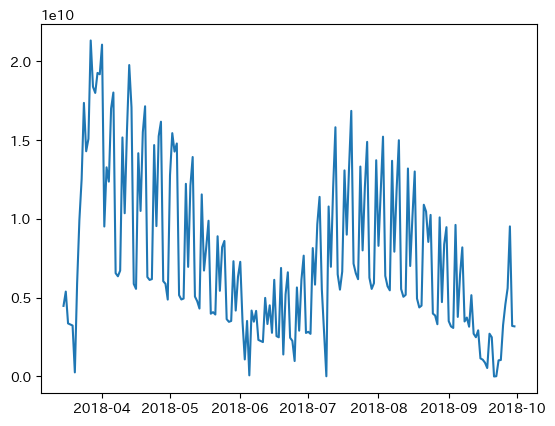

In [31]:
plt.plot(train_salesdata.total_sales)
plt.show()

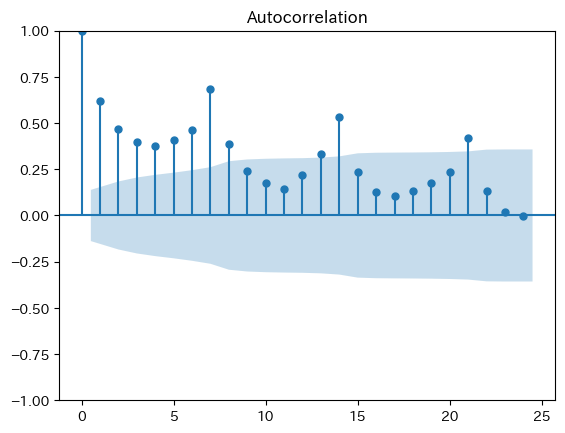

In [32]:
sm.graphics.tsa.plot_acf(train_salesdata.total_sales)
plt.show()
#7日間ごとに周期性あり。

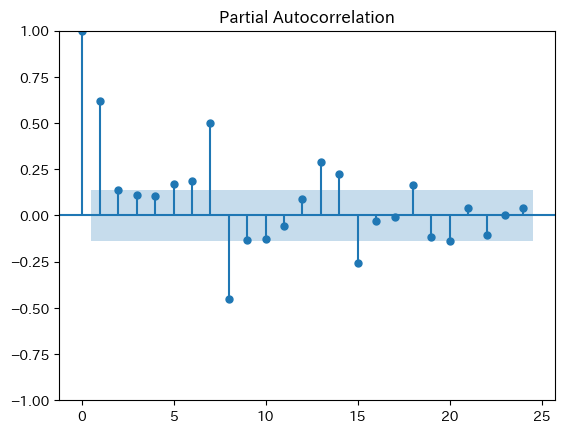

In [33]:
sm.graphics.tsa.plot_pacf(train_salesdata.total_sales)
plt.show()

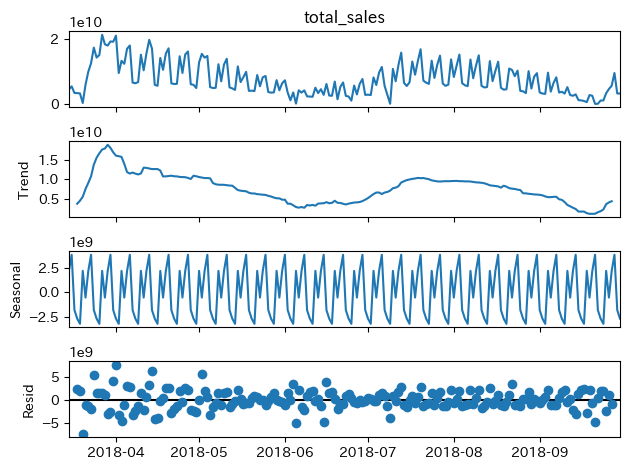

In [34]:
# 時系列データを傾向変動・季節変動・残差に分解する
decompose_result = sm.tsa.seasonal_decompose(train_salesdata.total_sales, period=7)

decompose_result.plot()
plt.show()

In [35]:
# logなし季節性考慮自動ARIMAモデルを構築
# model1= pm.auto_arima(train_salesdata,seasonal=True,m=7)

# # モデルのサマリーを表示
# print(model1.summary())

#autoだと自己回帰の次数は3,差分の次数が0,移動平均の次数が0と判断。

In [36]:
# # logなし季節性考慮自動ARIMAモデルを構築
# model2 = pm.auto_arima(train_salesdata,seasonal=True,m=4)

# # モデルのサマリーを表示
# print(model2.summary())

#autoだと自己回帰の次数は3,差分の次数が0,移動平均の次数が0と判断。

In [37]:
# # logなし季節性考慮自動ARIMAモデルを構築
# model3 = pm.auto_arima(train_salesdata)

# # モデルのサマリーを表示
# print(model3.summary())

#autoだと自己回帰の次数は3,差分の次数が0,移動平均の次数が0と判断。

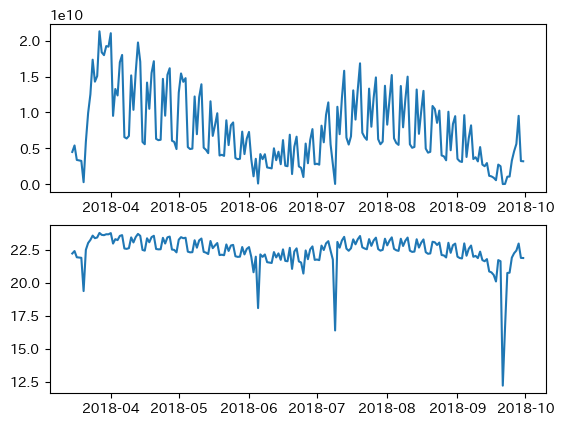

In [38]:
#週の季節性を考慮したほうが良いAIC
#次にlogありとなしを作成する

train_sales_log = np.log(train_salesdata)

fig = plt.figure()
ax = fig.add_subplot(211)
plt.plot(train_salesdata.total_sales)
ax = fig.add_subplot(212)
plt.plot(train_sales_log) 
plt.show() #scaleが異なるので, facets

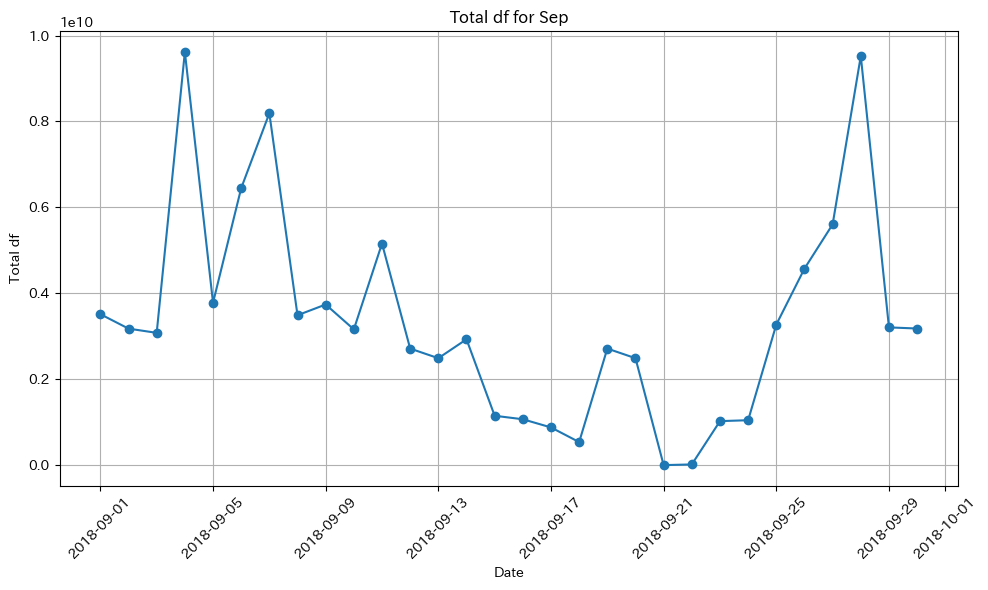

In [39]:
# 9月以降を一旦チェック
september_data = train_salesdata['2018-09':]

# データをプロット
plt.figure(figsize=(10, 6))
plt.plot(september_data.index, september_data['total_sales'], marker='o', linestyle='-')
plt.title('Total df for Sep')
plt.xlabel('Date')
plt.ylabel('Total df')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# プロットを表示
plt.show()

In [40]:
# logあり季節性考慮自動ARIMAモデルを構築
# model_log = pm.auto_arima(train_sales_log,seasonal=True,m=7)

# # モデルのサマリーを表示
# print(model_log.summary())

#autoだと自己回帰の次数は3,差分の次数が0,移動平均の次数が0と判断。

In [41]:
# # model1にて10月1ヶ月分の予測（31日間）
# forecast = model1.predict(n_periods=31)

# # 結果を表示
# print(forecast)

In [42]:
# # モデルのフィット確認のための予測値を生成
# predicted = model1.predict_in_sample()

# # グラフの描画
# plt.figure(figsize=(14, 7))
# plt.plot(train_salesdata.index, train_salesdata, color='black', label='元データ')
# plt.plot(train_salesdata.index, predicted, color='red', linestyle='dashed', label='予測値')
# plt.xlabel('Date')
# plt.ylabel('df')
# plt.title('元データと予測値の比較')
# plt.legend()
# plt.show()

In [43]:
# plt.plot(model1.resid())
# plt.show()

In [44]:
# sm.graphics.tsa.plot_acf(model1.resid()) 
# plt.show()

In [45]:
# plt.hist(model1.resid())

In [46]:
# # モデルのフィット確認のための予測値を生成
# predicted_log = model_log.predict_in_sample()

# # グラフの描画
# plt.figure(figsize=(14, 7))
# plt.plot(train_sales_log.index, train_sales_log, color='black', label='元データ')
# plt.plot(train_sales_log.index, predicted_log, color='red', linestyle='dashed', label='予測値')
# plt.xlabel('Date')
# plt.ylabel('df')
# plt.title('元データと予測値の比較')
# plt.legend()
# plt.show()

# #当てはまり微妙。。。

In [47]:
# #model1の予測値で一旦10月データとはめる
# # 予測値と95%信頼区間の取得
# forecast, conf_int = model1.predict(n_periods=31, return_conf_int=True)

# # 予測期間の日付インデックスを作成
# forecast_index = pd.date_range(start=test_salesdata.index[0], periods=31, freq='D')

# # 予測値のデータフレームを作成
# forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Forecast'])

# # 信頼区間のデータフレームを作成
# conf_int_df = pd.DataFrame(conf_int, index=forecast_index, columns=['Lower CI', 'Upper CI'])

# # グラフの描画
# plt.figure(figsize=(14, 7))
# plt.plot(train_salesdata.index, train_salesdata, color='black', label='Train Data')
# plt.plot(test_salesdata.index, test_salesdata, color='blue', label='Test Data')
# plt.plot(forecast_df.index, forecast_df, color='red', linestyle='dashed', label='Forecast')
# plt.fill_between(conf_int_df.index, conf_int_df['Lower CI'], conf_int_df['Upper CI'], color='pink', alpha=0.3, label='95% Confidence Interval')
# plt.xlabel('Date')
# plt.ylabel('df')
# plt.title('df Forecast vs Actuals')
# plt.legend()
# plt.show()

# クラスタリングを活用し別アプローチ

In [49]:
#別のアプローチを考える
#粒度を細かくし、クラスタリングでグループ分けした上で、まずはEDA
#別紙のexcelにて細かい分析ずみ

df2 = df.drop(columns=['film_code','occu_perc','month','quarter','day'])

grouped_df2 = df2.groupby(['cinema_code','date','cluster']).sum().reset_index()

grouped_df2.dtypes

cinema_code              int64
date            datetime64[ns]
cluster                float64
total_sales              int64
tickets_sold             int64
tickets_out              int64
show_time                int64
ticket_price           float64
ticket_use               int64
capacity               float64
dtype: object

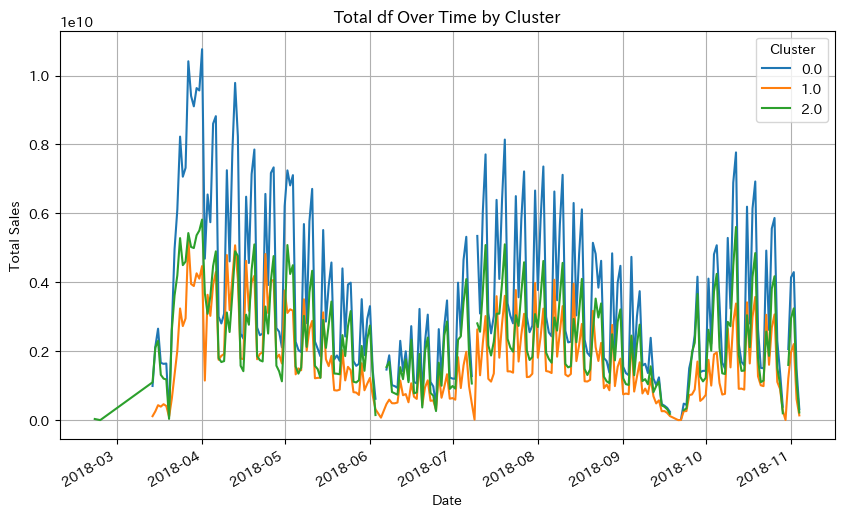

In [50]:
df2_dailysales = grouped_df2.groupby(['date', 'cluster'])['total_sales'].sum().unstack()

df2_dailysales.plot(kind='line', figsize=(10, 6))
plt.title('Total df Over Time by Cluster')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

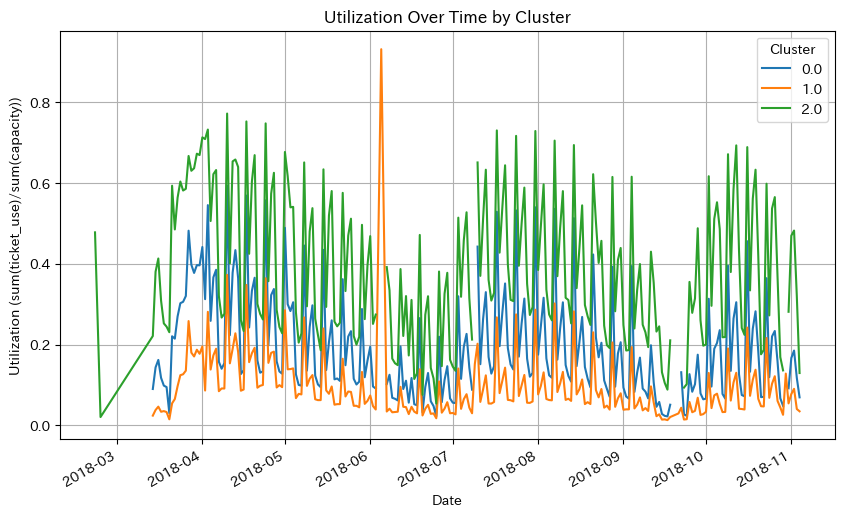

In [51]:
# グループごとにsum(ticket_use)/sum(capacity)を計算し、時系列プロット図を作成
utilization_by_cluster_date = grouped_df2.groupby(['date', 'cluster']).apply(lambda x: x['ticket_use'].sum() / x['capacity'].sum()).unstack()

utilization_by_cluster_date.plot(kind='line', figsize=(10, 6))
plt.title('Utilization Over Time by Cluster')
plt.xlabel('Date')
plt.ylabel('Utilization (sum(ticket_use)/sum(capacity))')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

#カテゴライズ1の占有率がずっと低い。。。。

In [52]:
# # クラスタごとのヒストグラムを個別に作成
# clusters = df2['cluster'].unique()
# for cluster in clusters:
#     subset = df2[df2['cluster'] == cluster]
#     plt.figure(figsize=(10, 6))
#     plt.hist(subset['ticket_price'], bins=10, alpha=0.7)
#     plt.title(f'Distribution of Ticket Prices for Cluster {int(cluster)}')
#     plt.xlabel('Ticket Price')
#     plt.ylabel('Frequency')
#     plt.grid(True)
#     plt.show()

In [53]:
#カテゴリ1の専有率が気になる。ここに何からしら課題があり、アプローチできるのでは？
#チケット数を予測（＝来店数）できれば、コストや売り上げの面で何かしらのアプローチが可能。チケット数の予測モデルを作成する。
#チケットの欠損値処理
df2_cluster1 = df2[df2['cluster']==1]

df2_cluster1 = df2_cluster1[["date","tickets_sold"]].set_index('date')

df2_cluster1 = df2_cluster1.resample('D').sum()


In [54]:
df2_cluster1_error = df2_cluster1[df2_cluster1['tickets_sold']<300]

df2_cluster1_error

,tickets_sold
date,
2018-06-04,0
2018-06-06,0
2018-07-09,239
2018-09-19,0
2018-09-20,0
2018-09-21,8
2018-09-22,101
2018-10-30,69


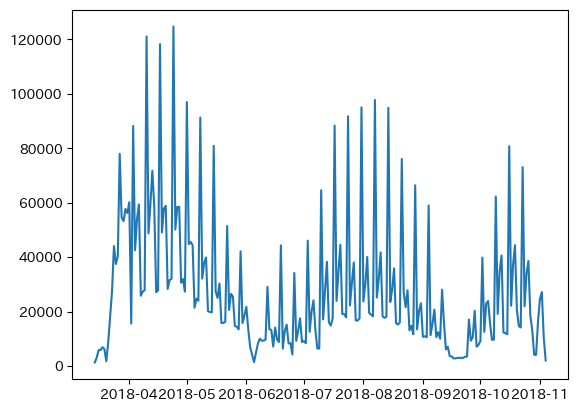

In [55]:

# 手動で欠損値を入力
#前後の値の平均値等で入力

df2_cluster1.loc['2018-06-04', 'tickets_sold'] = 4154  
df2_cluster1.loc['2018-06-06', 'tickets_sold'] = 4811  
df2_cluster1.loc['2018-07-09', 'tickets_sold'] = 6426  
df2_cluster1.loc['2018-09-19', 'tickets_sold'] = 3000  
df2_cluster1.loc['2018-09-20', 'tickets_sold'] = 3000 
df2_cluster1.loc['2018-09-21', 'tickets_sold'] = 3000
df2_cluster1.loc['2018-09-22', 'tickets_sold'] = 3000
df2_cluster1.loc['2018-10-30', 'tickets_sold'] = 4131


# 結果を表示
plt.plot(df2_cluster1.tickets_sold)
plt.show()

In [56]:
df2_cluster1[df2_cluster1['tickets_sold']<300]

,tickets_sold
date,


In [57]:
df2_cluster1

,tickets_sold
date,
2018-03-14,1306
2018-03-15,3087
2018-03-16,5859
2018-03-17,5853
2018-03-18,6906
...,...
2018-10-31,16216
2018-11-01,24520
2018-11-02,27178


# sarima,prophet,lightbgm にてモデルを作成し、予測精度を比べる

In [59]:
#2018/3/14~2018/11/4のデータ
#傾向は売り上げの時系列傾向と一緒のため割愛
#データを10月を起点に分割

split_date = pd.Timestamp('2018-10-01')

# データを分割
train_tickets_data = df2_cluster1[df2_cluster1.index < split_date]
test_tickets_data = df2_cluster1[df2_cluster1.index >= split_date]

## Sarimaから作成

In [61]:
model_tickets_sarima = pm.auto_arima(train_tickets_data,seasonal=True,m=7)

/opt/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(1,1,0)(2,0,1)[7] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/pmdarima/arima/_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/pmdarima/arima/arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "/opt/anaconda3/lib/python3.11/site-packages/pmdarima/arima/arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/pmdarima/arima/arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py", line 704, in fit
    mlefi

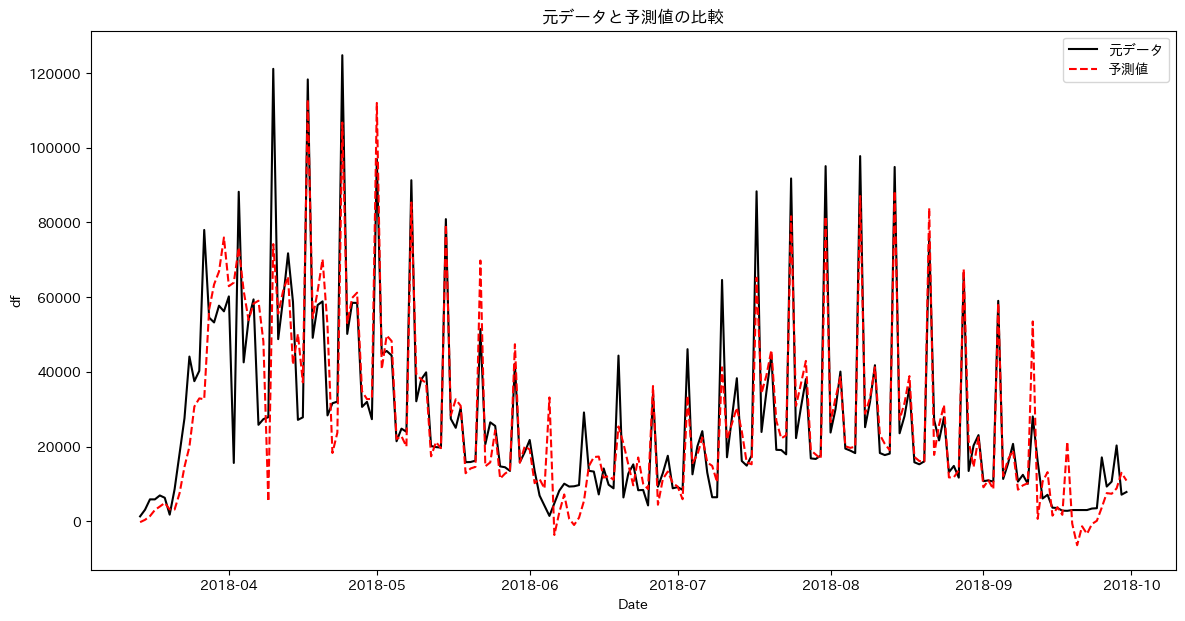

In [62]:
# モデルのフィット確認のための予測値を生成
predicted = model_tickets_sarima.predict_in_sample()

# グラフの描画
plt.figure(figsize=(14, 7))
plt.plot(train_tickets_data.index,train_tickets_data, color='black', label='元データ')
plt.plot(train_tickets_data.index, predicted, color='red', linestyle='dashed', label='予測値')
plt.xlabel('Date')
plt.ylabel('df')
plt.title('元データと予測値の比較')
plt.legend()
plt.show()

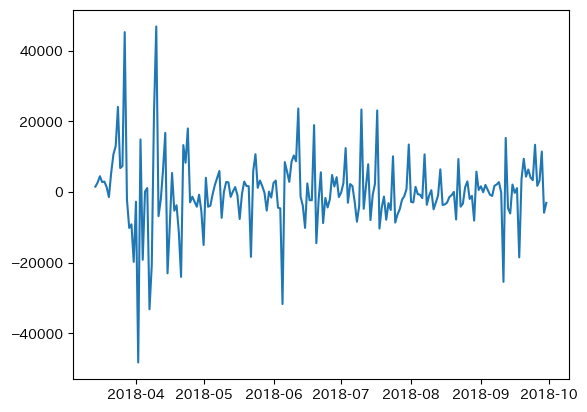

In [63]:
plt.plot(model_tickets_sarima.resid())
plt.show()

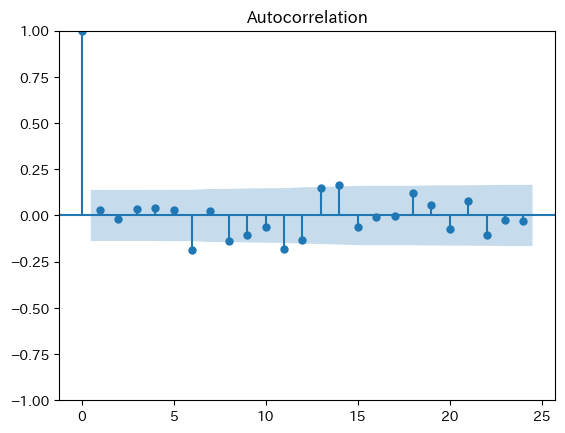

In [64]:
sm.graphics.tsa.plot_acf(model_tickets_sarima.resid()) 
plt.show()

(array([ 1.,  2.,  5.,  7., 80., 81., 17.,  6.,  0.,  2.]),
 array([-48267.09721403, -38750.21476171, -29233.33230938, -19716.44985706,
        -10199.56740473,   -682.68495241,   8834.19749991,  18351.07995224,
         27867.96240456,  37384.84485689,  46901.72730921]),
 <BarContainer object of 10 artists>)

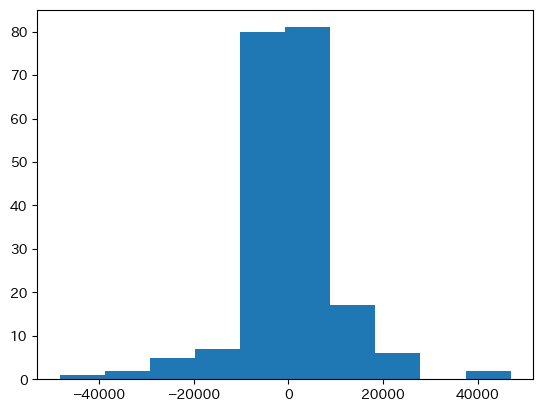

In [65]:
plt.hist(model_tickets_sarima.resid())

In [66]:
#10月以降の数値を予測
from sklearn.metrics import mean_squared_error

# 10月1ヶ月分の予測（31日間）
forecast = model_tickets_sarima.predict(n_periods=31)

# 結果を表示
print(forecast)

october_test_data = test_tickets_data.loc['2018-10-01':'2018-10-31']

# 予測値（forecast）の取得
# 既に 'forecast' に31日間の予測値が入っていることを仮定
forecast_values = forecast

# RMSEの計算
rmse = np.sqrt(mean_squared_error(october_test_data, forecast_values))

# 結果の表示
print("RMSE:", rmse)

2018-10-01     9603.942342
2018-10-02    20404.249171
2018-10-03    14129.733225
2018-10-04    15023.973356
2018-10-05    22528.819224
2018-10-06    12216.802135
2018-10-07    12784.166487
2018-10-08    14130.413772
2018-10-09    23773.560089
2018-10-10    18131.078764
2018-10-11    18906.171283
2018-10-12    25599.173413
2018-10-13    16342.262825
2018-10-14    16824.731432
2018-10-15    18004.467276
2018-10-16    26611.706811
2018-10-17    21535.031994
2018-10-18    22203.461853
2018-10-19    28169.689758
2018-10-20    19857.325729
2018-10-21    20263.794441
2018-10-22    21294.466841
2018-10-23    28974.347683
2018-10-24    24404.191014
2018-10-25    24977.134921
2018-10-26    30292.744056
2018-10-27    22825.951732
2018-10-28    23164.384241
2018-10-29    24061.612896
2018-10-30    30911.308859
2018-10-31    26794.594543
Freq: D, dtype: float64
RMSE: 17474.176487189532


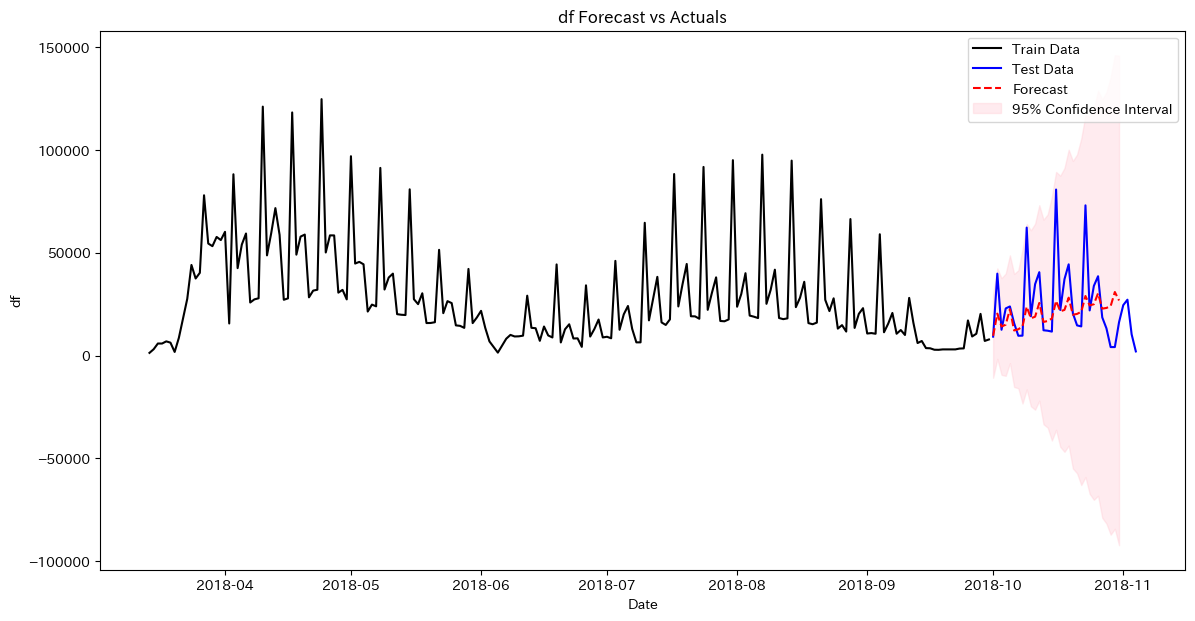

In [67]:
#model1の予測値で一旦10月データとはめる
# 予測値と95%信頼区間の取得
forecast, conf_int = model_tickets_sarima.predict(n_periods=31, return_conf_int=True)

# 予測期間の日付インデックスを作成
forecast_index = pd.date_range(start=test_tickets_data.index[0], periods=31, freq='D')

# 予測値のデータフレームを作成
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Forecast'])

# 信頼区間のデータフレームを作成
conf_int_df = pd.DataFrame(conf_int, index=forecast_index, columns=['Lower CI', 'Upper CI'])

# グラフの描画
plt.figure(figsize=(14, 7))
plt.plot(train_tickets_data.index, train_tickets_data, color='black', label='Train Data')
plt.plot(test_tickets_data.index, test_tickets_data, color='blue', label='Test Data')
plt.plot(forecast_df.index, forecast_df, color='red', linestyle='dashed', label='Forecast')
plt.fill_between(conf_int_df.index, conf_int_df['Lower CI'], conf_int_df['Upper CI'], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('df')
plt.title('df Forecast vs Actuals')
plt.legend()
plt.show()

#売り上げと同じ傾向のtickestddataは、sarimaモデルでも同じ傾向。
#不規則な周期だから予測しきれないのか・・＿？？？

## 続いてprophetモデル

In [69]:
! pip install prophet scikit-learn
from prophet import Prophet

21:07:02 - cmdstanpy - INFO - Chain [1] start processing
21:07:02 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 17364.974813051318


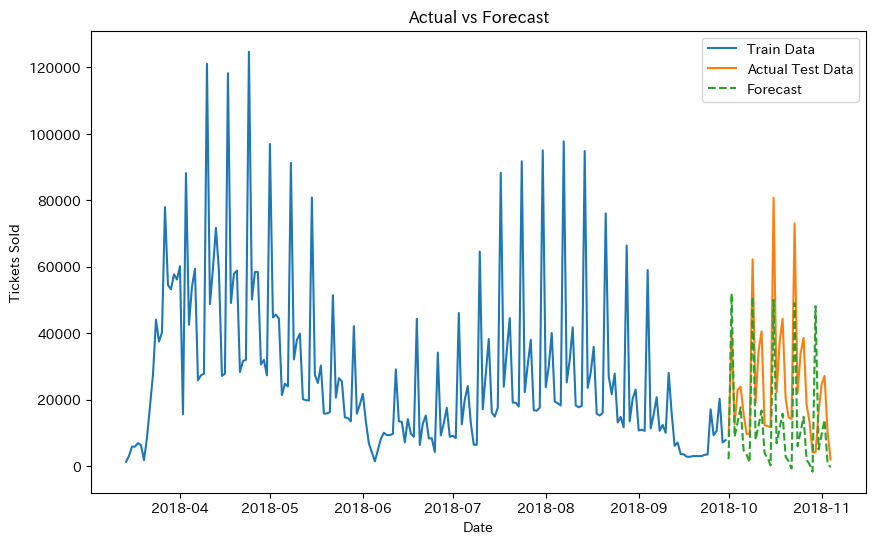

In [70]:

# Prophetが扱いやすいようにデータフレームの列名を変更
train_tickets_data2 = train_tickets_data.reset_index(inplace=False).rename(columns={'date': 'ds', 'tickets_sold': 'y'})
test_tickets_data2 = test_tickets_data.reset_index(inplace=False).rename(columns={'date': 'ds', 'tickets_sold': 'y'})

# Prophetモデルの作成とフィッティング
model_tickets_prophet = Prophet()
model_tickets_prophet.fit(train_tickets_data2)

# 将来のデータフレームの作成
future = model_tickets_prophet.make_future_dataframe(periods=len(test_tickets_data2))

# 予測の実行
forecast = model_tickets_prophet.predict(future)

# テスト期間の予測値を取得
test_forecast2 = forecast[forecast['ds'].isin(test_tickets_data2['ds'])]

# RMSEの計算
rmse = np.sqrt(mean_squared_error(test_tickets_data2['y'], test_forecast2['yhat']))
print(f'RMSE: {rmse}')

# 実際の値と予測値のプロット
plt.figure(figsize=(10, 6))
plt.plot(train_tickets_data2['ds'], train_tickets_data2['y'], label='Train Data')
plt.plot(test_tickets_data2['ds'], test_tickets_data2['y'], label='Actual Test Data')
plt.plot(test_forecast2['ds'], test_forecast2['yhat'], label='Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Tickets Sold')
plt.title('Actual vs Forecast')
plt.legend()
plt.show()

21:07:02 - cmdstanpy - INFO - Chain [1] start processing
21:07:02 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 12312.72175797807


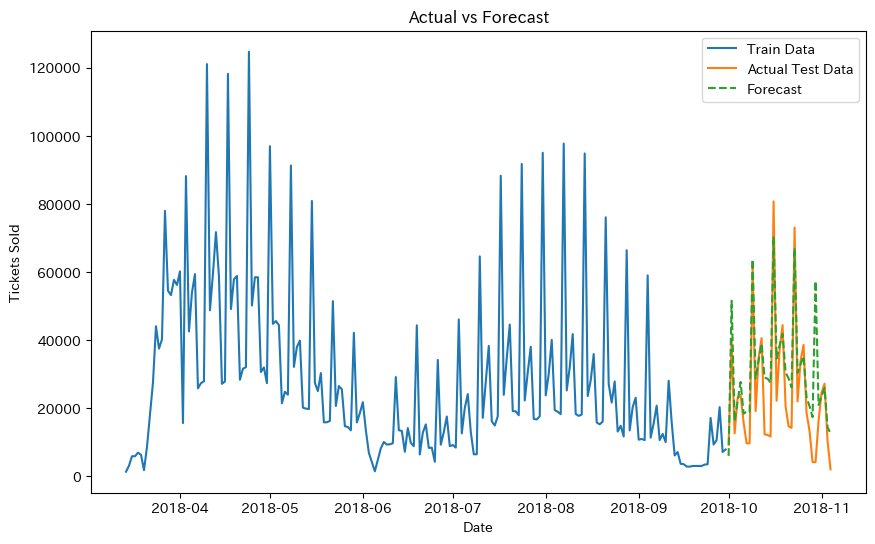

In [71]:
#少しチューニング
# Prophetが扱いやすいようにデータフレームの列名を変更
train_tickets_data2 = train_tickets_data.reset_index(inplace=False).rename(columns={'date': 'ds', 'tickets_sold': 'y'})
test_tickets_data2 = test_tickets_data.reset_index(inplace=False).rename(columns={'date': 'ds', 'tickets_sold': 'y'})

# 休日データの作成（例として日本の祝日を使用）
holidays = pd.DataFrame({
    'holiday': 'japan_holiday',
    'ds': pd.to_datetime(['2018-03-21', '2018-04-29', '2018-04-30', '2018-05-03', '2018-05-04', '2018-05-05', '2018-07-16', '2018-08-11', '2018-09-17', '2018-09-23', '2018-09-24']),
    'lower_window': 0,
    'upper_window': 1,
})

# Prophetモデルの作成とフィッティング
model_tickets_prophet = Prophet(holidays=holidays,
                                yearly_seasonality=True,
                                weekly_seasonality=True,
                                daily_seasonality=False,
                                seasonality_mode='multiplicative',
                                changepoint_prior_scale=0.05,
                                seasonality_prior_scale=10.0)

# 追加の季節性（週ごとのパターンなど）
model_tickets_prophet.add_seasonality(name='weekly', period=7, fourier_order=3)
model_tickets_prophet.fit(train_tickets_data2)

# 将来のデータフレームの作成
future = model_tickets_prophet.make_future_dataframe(periods=len(test_tickets_data2))

# 予測の実行
forecast = model_tickets_prophet.predict(future)

# テスト期間の予測値を取得
test_forecast2 = forecast[forecast['ds'].isin(test_tickets_data2['ds'])]

# RMSEの計算
rmse = np.sqrt(mean_squared_error(test_tickets_data2['y'], test_forecast2['yhat']))
print(f'RMSE: {rmse}')

# 実際の値と予測値のプロット
plt.figure(figsize=(10, 6))
plt.plot(train_tickets_data2['ds'], train_tickets_data2['y'], label='Train Data')
plt.plot(test_tickets_data2['ds'], test_tickets_data2['y'], label='Actual Test Data')
plt.plot(test_forecast2['ds'], test_forecast2['yhat'], label='Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Tickets Sold')
plt.title('Actual vs Forecast')
plt.legend()
plt.show()

In [72]:
#RMSEfittingは多少改善したが、図を見るだけでもあまり当てはまりは良くない

## 続いてlightbgmにて

In [74]:
# インデックスを列として追加
df2_cluster1_lgm = df2_cluster1.reset_index()

# 新しく追加された日付の列名を 'Date' に変更
df2_cluster1_lgm.rename(columns={'date': 'Date'}, inplace=True)

df2_cluster1_lgm

,Date,tickets_sold
0,2018-03-14,1306
1,2018-03-15,3087
2,2018-03-16,5859
3,2018-03-17,5853
4,2018-03-18,6906
...,...,...
231,2018-10-31,16216
232,2018-11-01,24520
233,2018-11-02,27178
234,2018-11-03,10327


In [75]:

# 2018年の全日付を作成
dates_2018 = pd.date_range(start='2018-01-01', end='2018-12-31')

# 祝日リストを取得
holiday_list = [date for date in dates_2018 if jpholiday.is_holiday(date)]

# データフレームに変換
holiday_list = pd.to_datetime(holiday_list)

print(holiday_list)

DatetimeIndex(['2018-01-01', '2018-01-08', '2018-02-11', '2018-02-12',
               '2018-03-21', '2018-04-29', '2018-04-30', '2018-05-03',
               '2018-05-04', '2018-05-05', '2018-07-16', '2018-08-11',
               '2018-09-17', '2018-09-23', '2018-09-24', '2018-10-08',
               '2018-11-03', '2018-11-23', '2018-12-23', '2018-12-24'],
              dtype='datetime64[ns]', freq=None)


In [76]:
# 特徴量エンジニアリング
#１年間のデータはないため、曜日の周期を予測に行かせる特徴量を追加。
#もっとデータがあれば、quaterやyearを入れても良かったか

df2_cluster1_lgm['lag_1'] = df2_cluster1_lgm['tickets_sold'].shift(1)
df2_cluster1_lgm['lag_4'] = df2_cluster1_lgm['tickets_sold'].shift(4)
df2_cluster1_lgm['lag_7'] = df2_cluster1_lgm['tickets_sold'].shift(7)
df2_cluster1_lgm['lag_30'] = df2_cluster1_lgm['tickets_sold'].shift(30)
df2_cluster1_lgm['rolling_mean_4'] = df2_cluster1_lgm['tickets_sold'].rolling(window=4).mean()
df2_cluster1_lgm['rolling_mean_7'] = df2_cluster1_lgm['tickets_sold'].rolling(window=7).mean()
df2_cluster1_lgm['rolling_mean_30'] = df2_cluster1_lgm['tickets_sold'].rolling(window=30).mean()
df2_cluster1_lgm['day_of_week'] = df2_cluster1_lgm['Date'].dt.dayofweek
# df2_cluster1_lgm['month'] = df2_cluster1_lgm['Date'].dt.month
# df2_cluster1_lgm['quarter'] = df2_cluster1_lgm['Date'].dt.quarter
# df2_cluster1_lgm['year'] = df2_cluster1_lgm['Date'].dt.year
df2_cluster1_lgm['is_holiday'] = df2_cluster1_lgm['Date'].isin(holiday_list).astype(int)

df2_cluster1_lgm

,Date,tickets_sold,lag_1,lag_4,lag_7,lag_30,rolling_mean_4,rolling_mean_7,rolling_mean_30,day_of_week,is_holiday
0,2018-03-14,1306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0
1,2018-03-15,3087,1306.0,NaN,NaN,NaN,NaN,NaN,NaN,3,0
2,2018-03-16,5859,3087.0,NaN,NaN,NaN,NaN,NaN,NaN,4,0
3,2018-03-17,5853,5859.0,NaN,NaN,NaN,4026.25,NaN,NaN,5,0
4,2018-03-18,6906,5853.0,1306.0,NaN,NaN,5426.25,NaN,NaN,6,0
...,...,...,...,...,...,...,...,...,...,...,...
231,2018-10-31,16216,4131.0,18562.0,21960.0,9205.0,9423.00,18387.428571,26155.333333,2,0
232,2018-11-01,24520,16216.0,13214.0,33870.0,39843.0,12249.50,17051.714286,25644.566667,3,0
233,2018-11-02,27178,24520.0,4131.0,38588.0,12555.0,18011.25,15421.714286,26132.000000,4,0
234,2018-11-03,10327,27178.0,4131.0,18562.0,22928.0,19560.25,14245.285714,25711.966667,5,1


In [77]:
# データを分割
train_tickets_lgm = df2_cluster1_lgm[df2_cluster1_lgm['Date'] < split_date]
test_tickets_lgm = df2_cluster1_lgm[df2_cluster1_lgm['Date'] >= split_date]

In [78]:
features = ['lag_1','lag_4', 'lag_7', 'lag_30','rolling_mean_4', 'rolling_mean_7', 'rolling_mean_30', 'day_of_week','is_holiday']
# X_train = train_tickets_lgm[features]
# y_train = train_tickets_lgm['tickets_sold']
# X_test = test_tickets_lgm[features]
# y_test = test_tickets_lgm['tickets_sold']

X = train_tickets_lgm[features]
y = train_tickets_lgm['tickets_sold']

In [ ]:

# Optunaでパラメータの最適化
def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'n_estimators': 1000,
        'early_stopping_rounds': 50,
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }

    tscv = TimeSeriesSplit(n_splits=5)
    rmse_list = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

        model = lgb.train(
            param,
            lgb_train,
            valid_sets=lgb_eval,
            callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=10)]
        )
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        rmse_list.append(rmse)

    return np.mean(rmse_list)

# Optunaのスタディを作成し、最適化を実行
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print('Best trial: RMSE: {}'.format(study.best_trial.value))
print('Best parameters: {}'.format(study.best_trial.params))

# 最適なモデルの訓練と評価
best_params = study.best_trial.params
best_params['objective'] = 'regression'
best_params['metric'] = 'rmse'
best_params['boosting_type'] = 'gbdt'
best_params['n_estimators'] = 1000
best_params['early_stopping_rounds'] = 50

tscv = TimeSeriesSplit(n_splits=5)
rmse_list = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    model = lgb.train(
        best_params,
        lgb_train,
        valid_sets=lgb_eval,
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=10)]
    )
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse_list.append(rmse)

print('Final RMSE: {}'.format(np.mean(rmse_list)))

[I 2024-06-03 21:07:03,292] A new study created in memory with name: no-name-55de5949-1d8a-4a85-a569-30265fc27deb
/var/folders/w1/xzrnyvxs5c3_y0n6nw68lnt80000gn/T/ipykernel_13814/127041982.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/var/folders/w1/xzrnyvxs5c3_y0n6nw68lnt80000gn/T/ipykernel_13814/127041982.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/var/folders/w1/xzrnyvxs5c3_y0n6nw68lnt80000gn/T/ipykernel_13814/127041982.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0.